In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import json
import os
import sys
import re
import warnings

In [3]:
from datetime import datetime

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# tsfresh for feature extraction
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters

In [6]:
# For modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
# Set up visualization
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

In [8]:
# Cell 2: Load and prepare the data
# Create DataFrame
df = pd.read_csv(os.path.join('backend', 'data', 'tqbr', 'SBER.csv'))

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Display basic information
print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

Data shape: (3153, 5)

First 5 rows:
             Open    High    Low  Close   Volume
Date                                            
2013-03-25  96.00  101.14  96.00  98.79   593680
2013-03-26  98.58   99.31  97.08  97.20  1283550
2013-03-27  97.90   98.00  95.39  96.75  1261950
2013-03-28  96.38   98.66  95.72  98.59  1971410
2013-03-29  98.60   99.09  98.32  98.76   782000

Data types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Basic statistics:
              Open         High          Low        Close        Volume
count  3153.000000  3153.000000  3153.000000  3153.000000  3.153000e+03
mean    193.393356   195.584516   190.994244   193.375363  6.904795e+07
std      81.515914    82.116946    80.768662    81.475245  5.826816e+07
min      53.040000    55.450000    47.210000    53.500000  5.936800e+05
25%     117.120000   119.550000   114.370000   118.200000  3.553228e+07
50%     201.000000   204.330000   197.580000   201.2

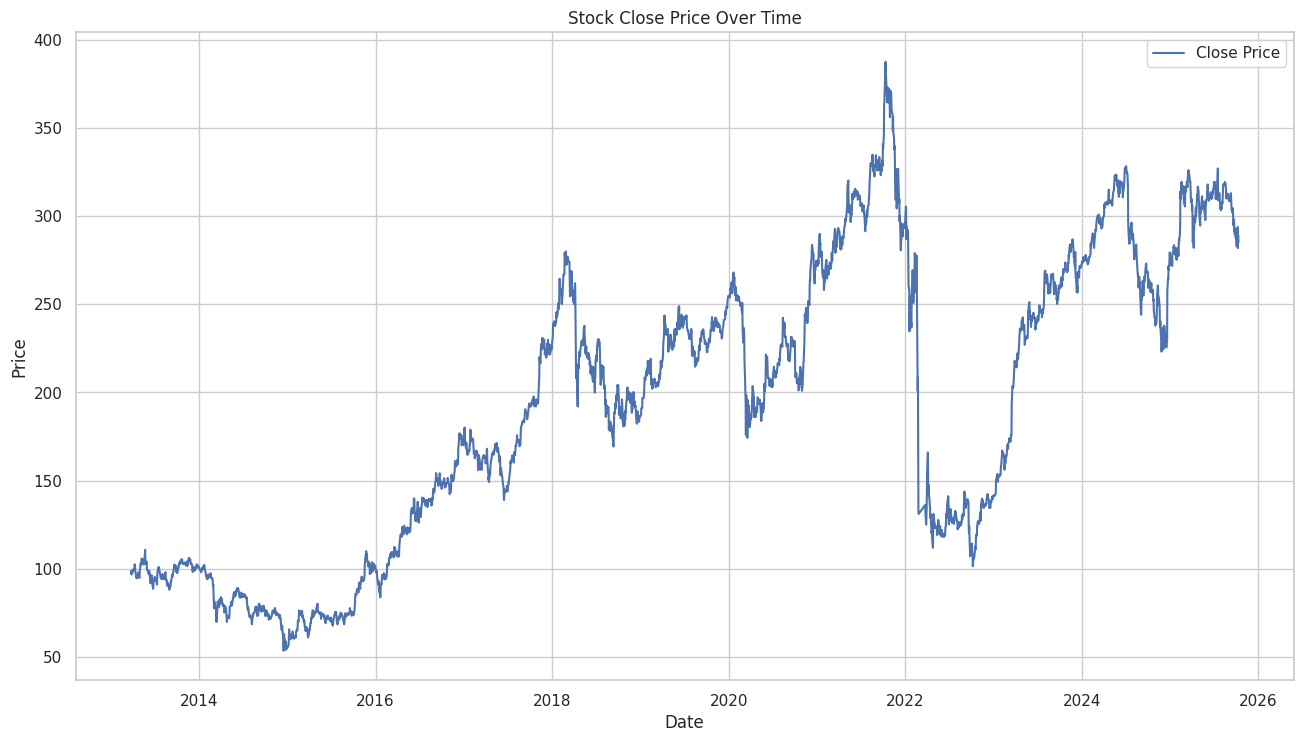

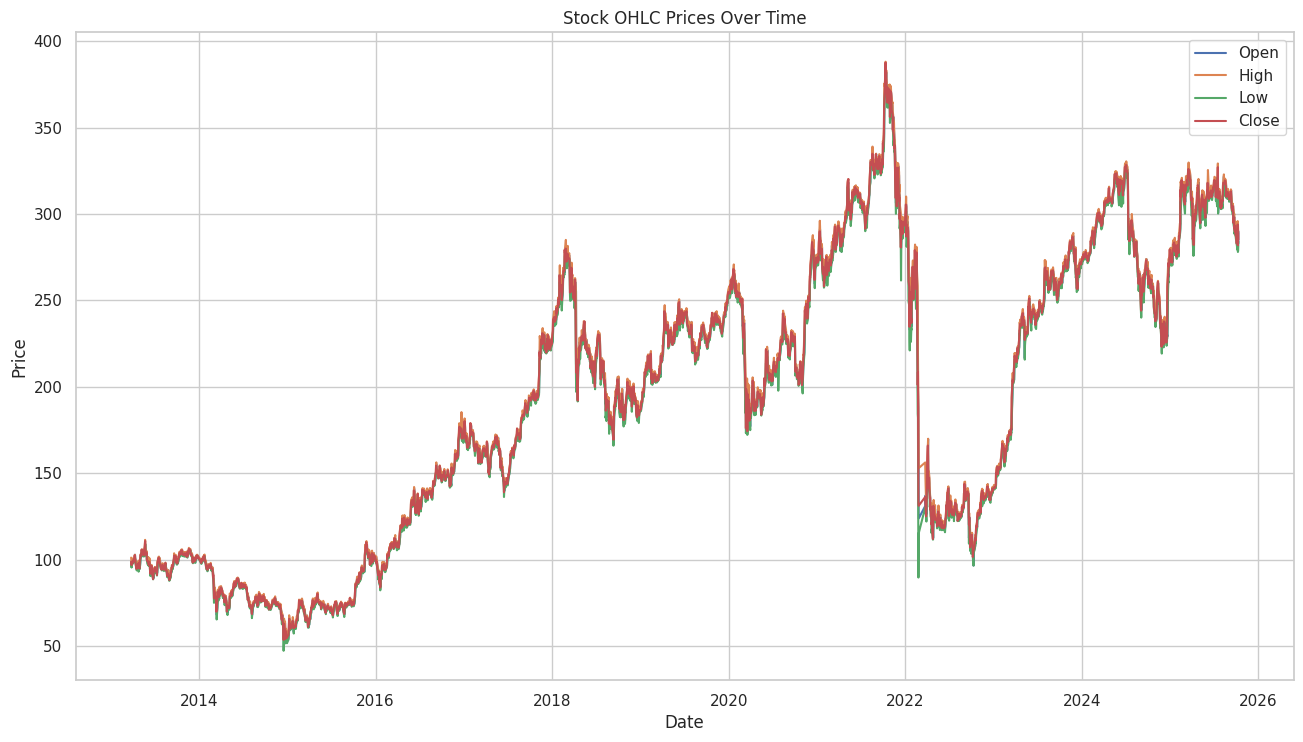

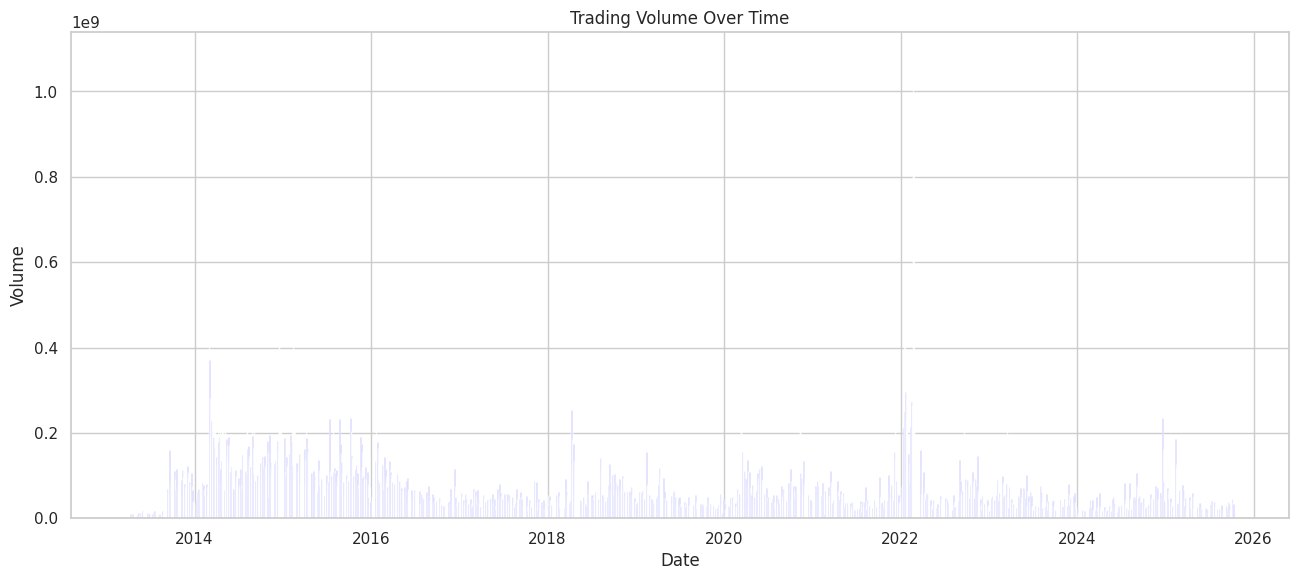

In [9]:
# Cell 3: Visualize the stock price data
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot all OHLC data
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Open'], label='Open')
plt.plot(df.index, df['High'], label='High')
plt.plot(df.index, df['Low'], label='Low')
plt.plot(df.index, df['Close'], label='Close')
plt.title('Stock OHLC Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Volume plot
plt.figure(figsize=(14, 6))
plt.bar(df.index, df['Volume'], color='blue', alpha=0.7)
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

              Open    High     Low   Close    Volume  Daily_Return  HL_Spread  \
Date                                                                            
2013-03-25   96.00  101.14   96.00   98.79    593680           NaN       5.14   
2013-03-26   98.58   99.31   97.08   97.20   1283550     -1.609475       2.23   
2013-03-27   97.90   98.00   95.39   96.75   1261950     -0.462963       2.61   
2013-03-28   96.38   98.66   95.72   98.59   1971410      1.901809       2.94   
2013-03-29   98.60   99.09   98.32   98.76    782000      0.172431       0.77   
2013-04-01   98.37   99.43   97.55   98.07   2279650     -0.698663       1.88   
2013-04-02   98.12   99.45   98.04   98.93   3555020      0.876925       1.41   
2013-04-03   98.90   99.71   98.69   99.59   3757240      0.667138       1.02   
2013-04-04   98.86  101.13   98.50   99.91   5172930      0.321317       2.63   
2013-04-05   99.88  100.84   98.40   99.38   5229210     -0.530477       2.44   
2013-04-08   99.97  100.78  

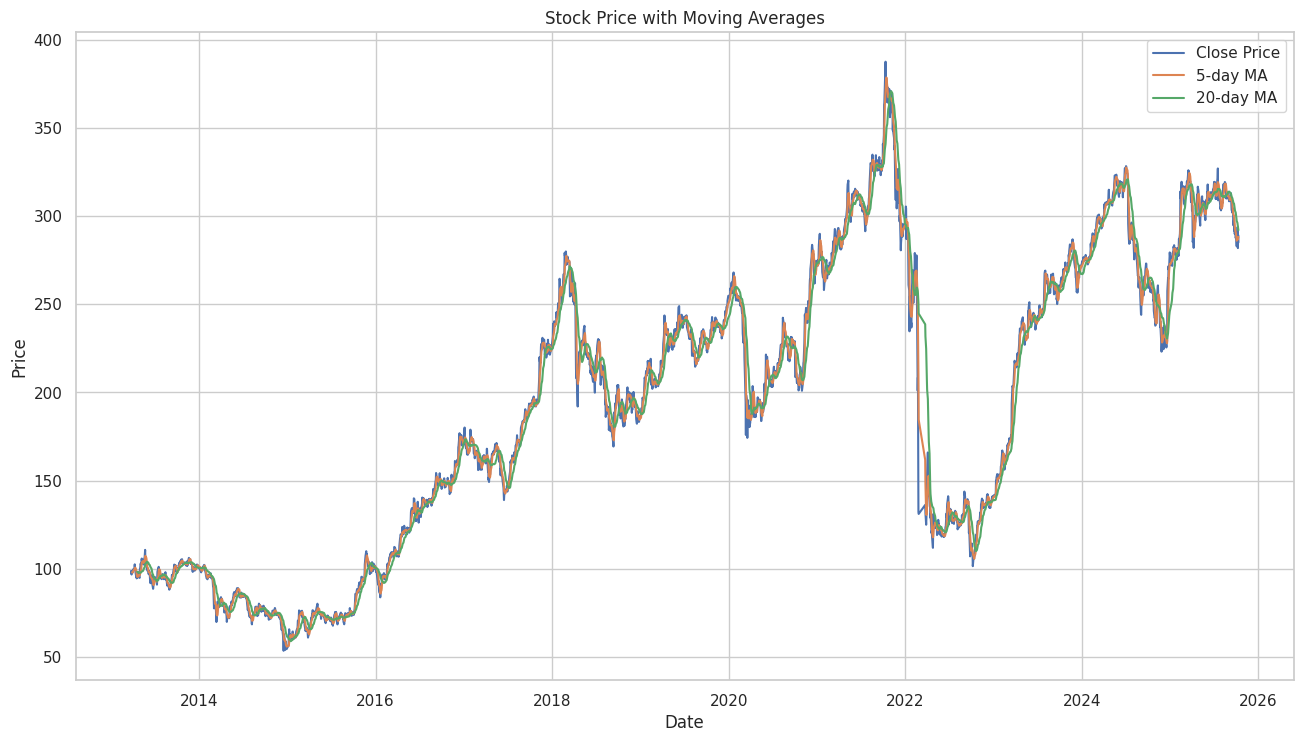

In [10]:
# Cell 4: Calculate additional features for analysis
# Daily returns
df['Daily_Return'] = df['Close'].pct_change() * 100

# High-Low spread
df['HL_Spread'] = df['High'] - df['Low']

# Open-Close spread
df['OC_Spread'] = df['Close'] - df['Open']

# 5-day and 20-day moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# Volatility (5-day rolling standard deviation)
df['Volatility'] = df['Daily_Return'].rolling(window=5).std()

# Display the updated dataframe
print(df.head(25))

# Plot with moving averages
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['MA_5'], label='5-day MA')
plt.plot(df.index, df['MA_20'], label='20-day MA')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Cell 5: Prepare data for tsfresh feature extraction
# Reset index to have Date as a column
df_tsfresh = df.reset_index()

# Create the id column for tsfresh (all same id for one time series)
df_tsfresh['id'] = 0

# Create a time column (number of days since start)
df_tsfresh['time'] = range(len(df_tsfresh))

# We'll extract features from the Close price
df_close = df_tsfresh[['Date', 'Close', 'id', 'time']].copy()
df_close.rename(columns={'Close': 'value'}, inplace=True)

print("Data prepared for tsfresh:")
print(df_close.head())

Data prepared for tsfresh:
        Date  value  id  time
0 2013-03-25  98.79   0     0
1 2013-03-26  97.20   0     1
2 2013-03-27  96.75   0     2
3 2013-03-28  98.59   0     3
4 2013-03-29  98.76   0     4


In [12]:
# Cell 6: Extract features using tsfresh
# Use EfficientFCParameters to limit the number of features
extraction_settings = EfficientFCParameters()

# Extract features - only include the columns tsfresh needs
print("Extracting features using tsfresh...")
extracted_features = extract_features(df_close[['value', 'id', 'time']], 
                                     column_id='id', 
                                     column_sort='time', 
                                     default_fc_parameters=extraction_settings, 
                                     n_jobs=0)  # n_jobs=0 uses all available cores

# Impute missing values
print("Imputing missing values...")
impute(extracted_features)

print(f"Extracted {extracted_features.shape[1]} features")
print("Sample of extracted features:")
print(extracted_features.head())

Extracting features using tsfresh...


Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]

Imputing missing values...
Extracted 777 features
Sample of extracted features:
   value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
0                                             1.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
0                       0.0                   1.0          609712.52   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
0       1.388270e+08                2.509933            0.059115   

   value__mean_second_derivative_central  value__median  ...  \
0                              -0.000422          201.2  ...   

   value__fourier_entropy__bins_5  value__fourier_entropy__bins_10  \
0                        0.125256                         0.125256   

   value__fourier_entropy__bins_100  \
0                           0.32514   

   value__permutation_entropy__dimension_3__tau_1  \
0                                        1.745883   

   value__permutation_e

In [13]:
# Cell 7: Analyze the most important features
# Let's look at some of the most interesting features
print("Statistical features of the time series:")
print(f"Mean: {extracted_features['value__mean'].values[0]:.2f}")
print(f"Standard deviation: {extracted_features['value__standard_deviation'].values[0]:.2f}")
print(f"Maximum: {extracted_features['value__maximum'].values[0]:.2f}")
print(f"Minimum: {extracted_features['value__minimum'].values[0]:.2f}")
print(f"Median: {extracted_features['value__median'].values[0]:.2f}")

Statistical features of the time series:
Mean: 193.38
Standard deviation: 81.46
Maximum: 387.60
Minimum: 53.50
Median: 201.20


In [14]:
# Cell 8: Prepare data for prediction
# We'll try to predict the next day's close price
df['Next_Close'] = df['Close'].shift(-1)

# Drop rows with NaN values
df.dropna(inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 
           'HL_Spread', 'OC_Spread', 'MA_5', 'MA_20', 'Volatility']
target = 'Next_Close'

X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 2506
Test set size: 627


In [15]:
# Cell 9: Train a simple model
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Mean Squared Error: 21.40
Mean Absolute Error: 3.36
Root Mean Squared Error: 4.63


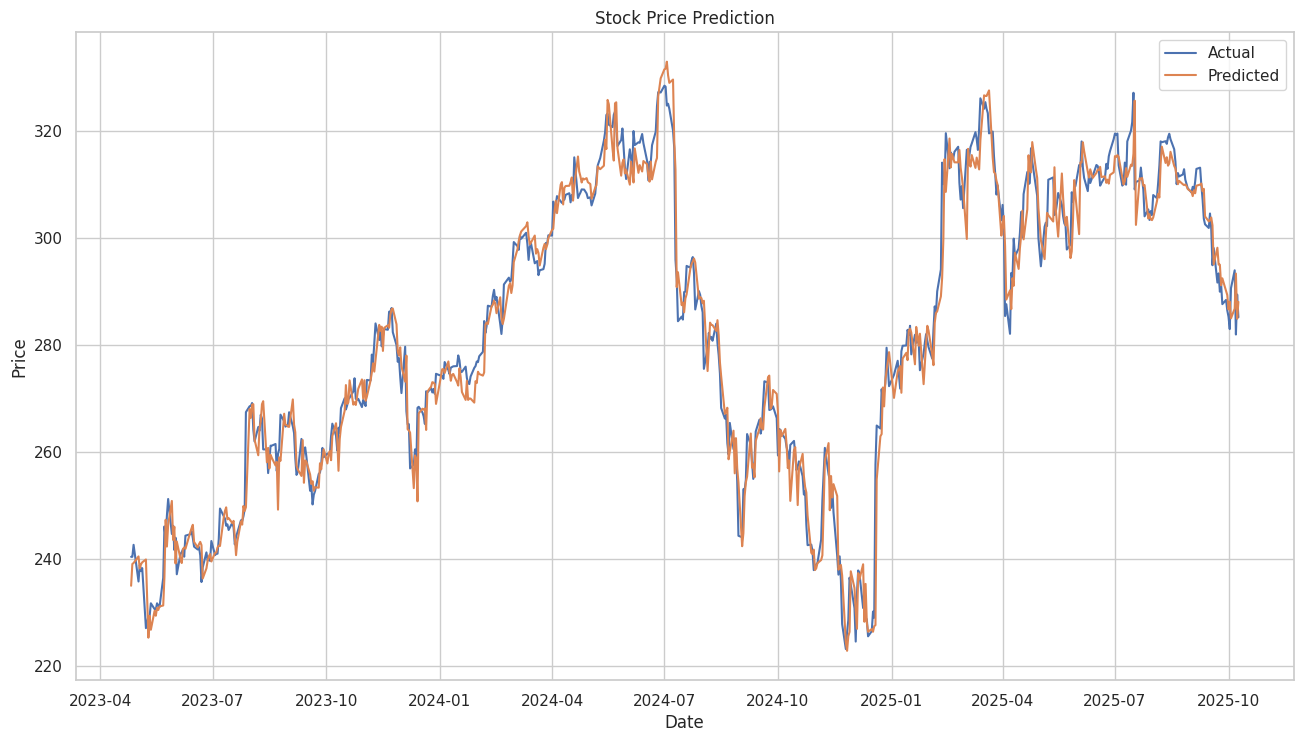

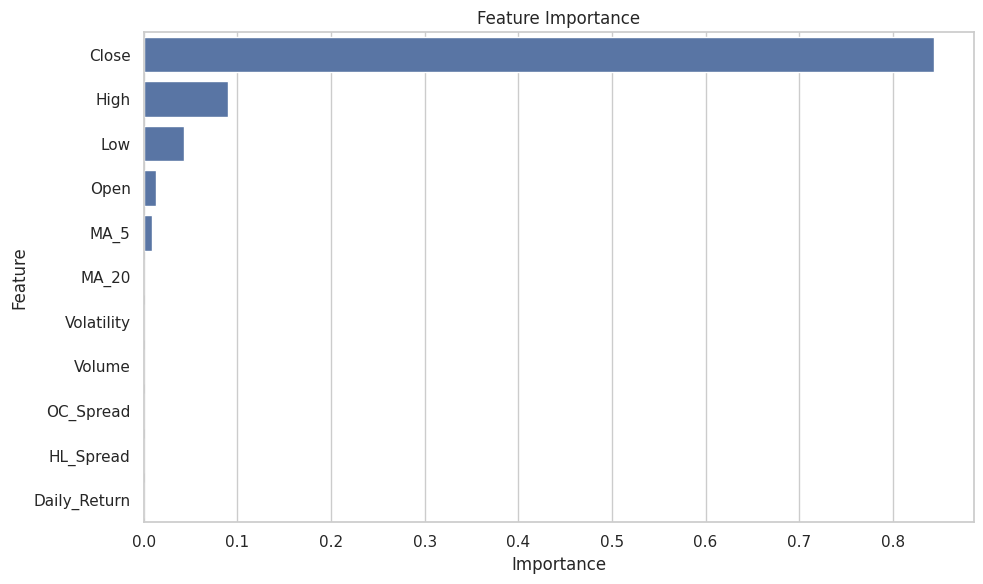

Feature Importance:
         Feature  Importance
3          Close    0.844465
1           High    0.089875
2            Low    0.043202
0           Open    0.012603
8           MA_5    0.008510
9          MA_20    0.000280
10    Volatility    0.000261
4         Volume    0.000245
7      OC_Spread    0.000188
6      HL_Spread    0.000186
5   Daily_Return    0.000184


In [16]:
# Cell 10: Visualize predictions
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

print("Feature Importance:")
print(feature_importance)

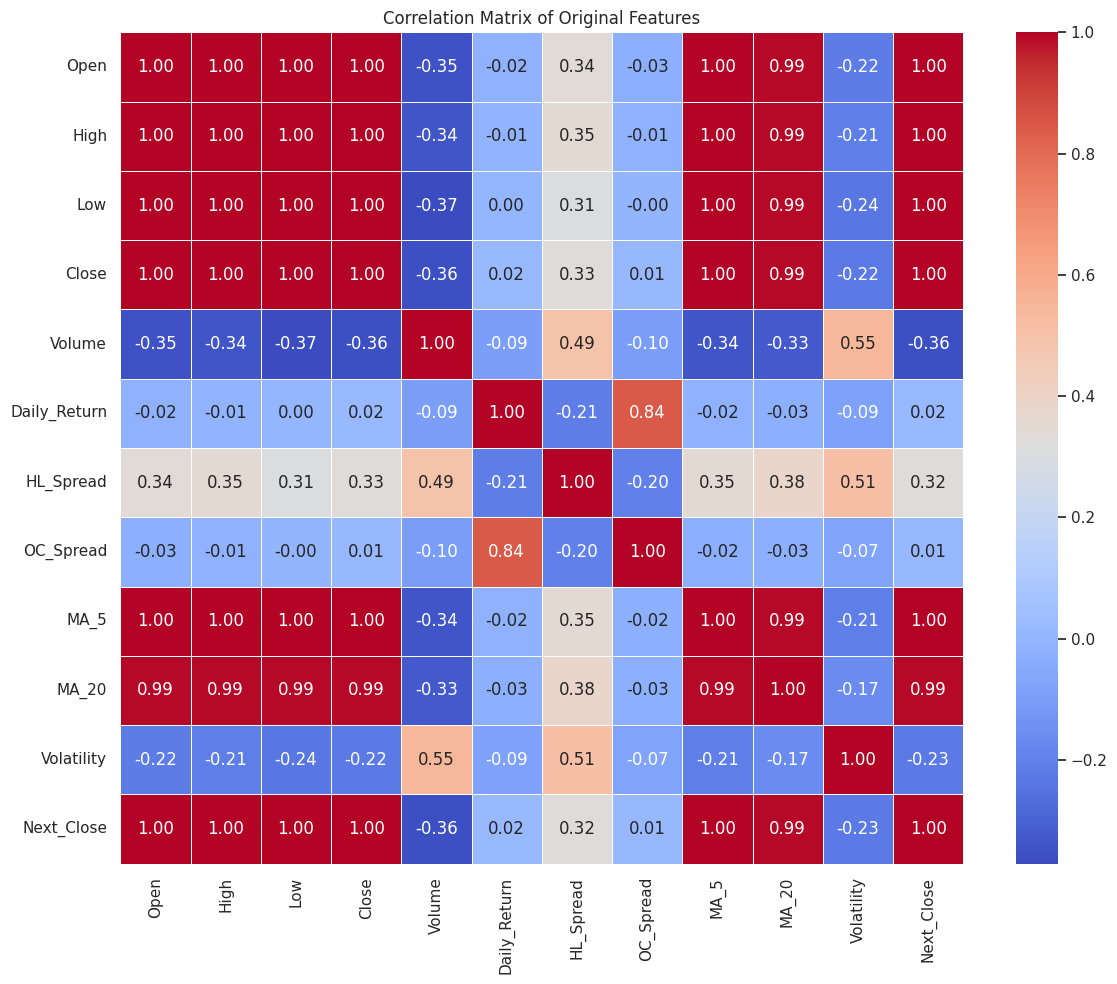

In [17]:
# Cell 11: Create a correlation matrix for the original features
plt.figure(figsize=(12, 10))
correlation_matrix = df[features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Original Features')
plt.tight_layout()
plt.show()

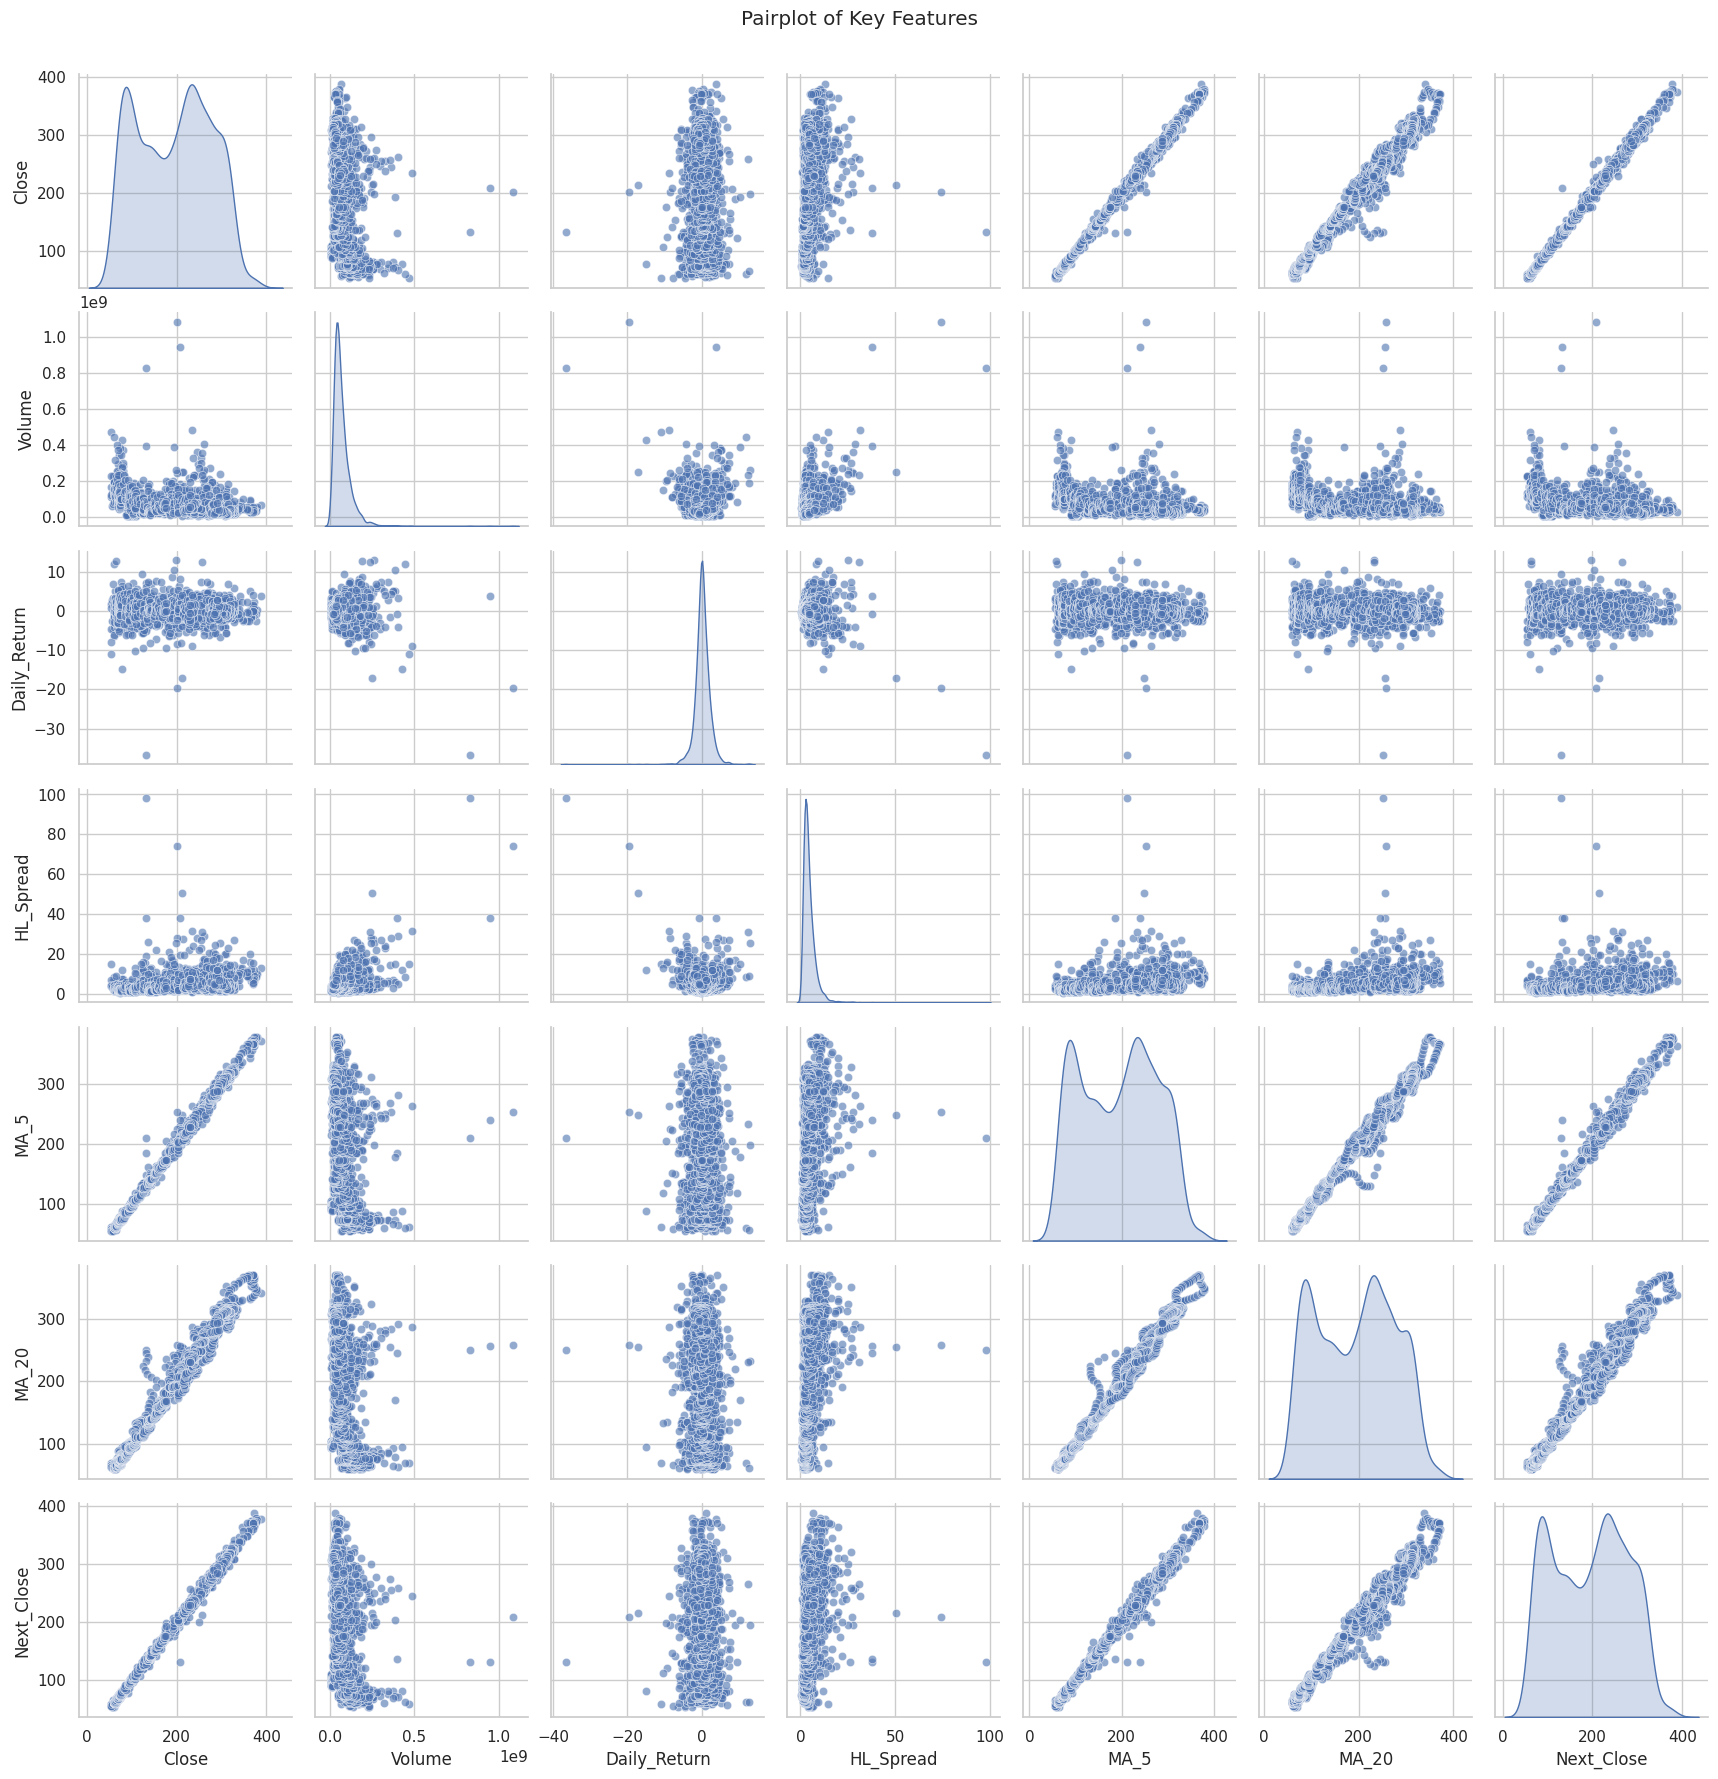

In [18]:
# Cell 12: Create a pairplot for key features
# Select a subset of features for the pairplot to avoid overcrowding
key_features = ['Close', 'Volume', 'Daily_Return', 'HL_Spread', 'MA_5', 'MA_20', 'Next_Close']
sns.pairplot(df[key_features].dropna(), diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

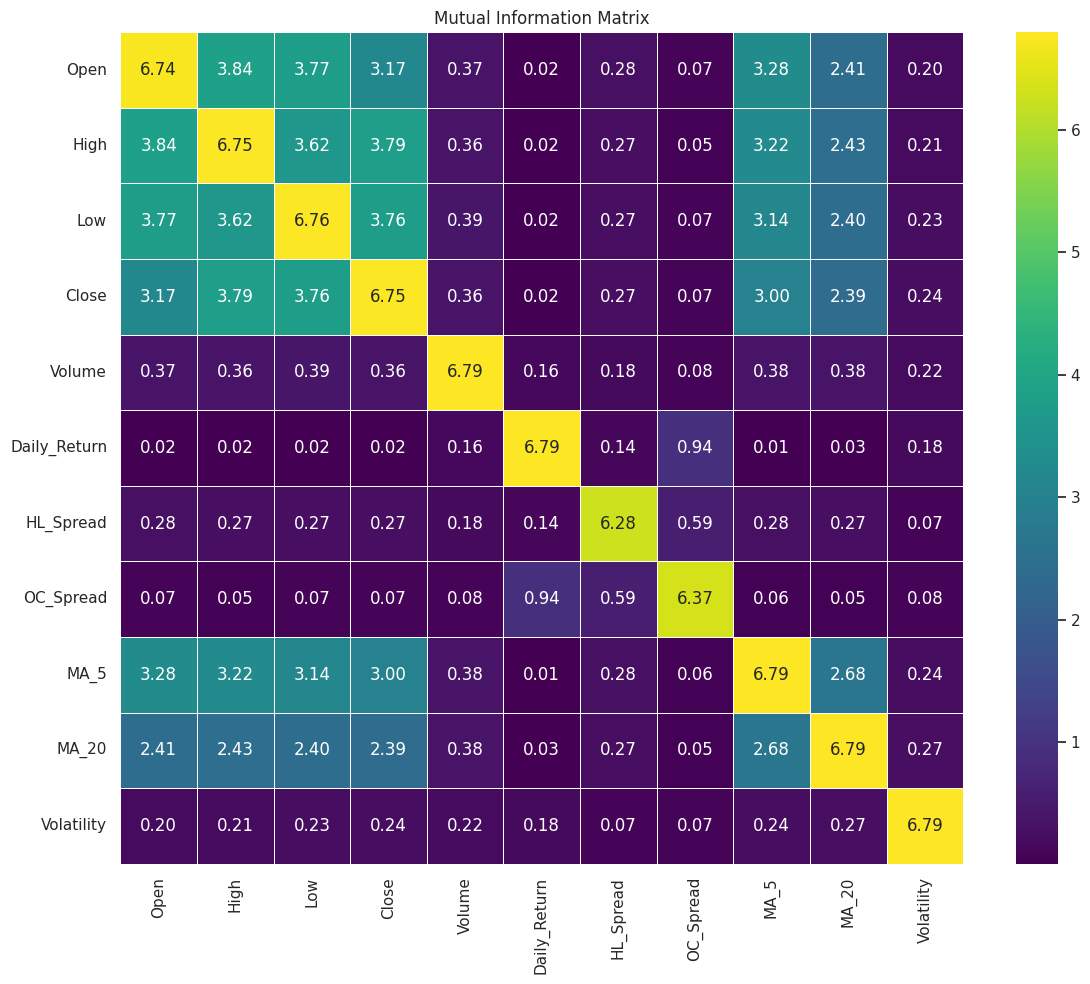

In [19]:
# Cell 13: Create a Mutual Information matrix
from sklearn.feature_selection import mutual_info_regression

# Calculate mutual information between features
mi_matrix = pd.DataFrame(index=features, columns=features)

for i in features:
    for j in features:
        mi_matrix.loc[i, j] = mutual_info_regression(df[[i]], df[j])[0]

# Convert to numeric
mi_matrix = mi_matrix.astype(float)

# Plot the MI matrix
plt.figure(figsize=(12, 10))
sns.heatmap(mi_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Mutual Information Matrix')
plt.tight_layout()
plt.show()

In [20]:
extracted_features.shape

(1, 777)

In [21]:
extracted_features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,609712.52,1.388270e+08,2.509933,0.059115,-0.000422,201.2,...,0.125256,0.125256,0.32514,1.745883,3.009447,4.409784,5.822608,6.966375,0.0,376.947143


In [21]:
# Cell 14: Prepare data with tsfresh features for prediction
# Merge the original features with the tsfresh features
# First, we need to reshape the tsfresh features to match our original dataframe
tsfresh_features_df = pd.DataFrame()
for col in extracted_features.columns:
    tsfresh_features_df[col] = [extracted_features[col].values[0]] * len(df)

# Combine with original features
df_with_tsfresh = df.copy()
for col in tsfresh_features_df.columns:
    df_with_tsfresh[col] = tsfresh_features_df[col].values

# Drop rows with NaN values
df_with_tsfresh.dropna(inplace=True)

# Define features and target
original_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 
                    'HL_Spread', 'OC_Spread', 'MA_5', 'MA_20', 'Volatility']

# Select a subset of tsfresh features to avoid overfitting
tsfresh_feature_subset = [
    'value__mean', 'value__standard_deviation', 'value__maximum', 'value__minimum',
    'value__median', 'value__variance', 'value__skewness', 'value__kurtosis',
    'value__absolute_sum_of_changes', 'value__longest_strike_above_mean',
    'value__longest_strike_below_mean', 'value__count_above_mean',
    'value__count_below_mean', 'value__first_location_of_maximum',
    'value__first_location_of_minimum', 'value__last_location_of_maximum',
    'value__last_location_of_minimum', 'value__linear_trend__attr_"slope"',
    'value__linear_trend__attr_"intercept"', 'value__augmented_dickey_fuller__attr_"teststat"'
]

# Check if all selected tsfresh features exist in the dataframe
existing_tsfresh_features = [f for f in tsfresh_feature_subset if f in df_with_tsfresh.columns]
print(f"Using {len(existing_tsfresh_features)} tsfresh features out of {len(tsfresh_feature_subset)} selected")

# Combine original and tsfresh features
all_features = original_features + existing_tsfresh_features
target = 'Next_Close'

X = df_with_tsfresh[all_features]
y = df_with_tsfresh[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training set size: {X_train.shape[0]} with {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} with {X_test.shape[1]} features")

Using 19 tsfresh features out of 20 selected
Training set size: 2506 with 30 features
Test set size: 627 with 30 features


In [22]:
# Cell 15: Train a model with tsfresh features
# Initialize and train the model
model_tsfresh = RandomForestRegressor(n_estimators=100, random_state=42)
model_tsfresh.fit(X_train, y_train)

# Make predictions
y_pred_tsfresh = model_tsfresh.predict(X_test)

# Evaluate the model
mse_tsfresh = mean_squared_error(y_test, y_pred_tsfresh)
mae_tsfresh = mean_absolute_error(y_test, y_pred_tsfresh)
rmse_tsfresh = np.sqrt(mse_tsfresh)

print(f"Model with tsfresh features:")
print(f"Mean Squared Error: {mse_tsfresh:.2f}")
print(f"Mean Absolute Error: {mae_tsfresh:.2f}")
print(f"Root Mean Squared Error: {rmse_tsfresh:.2f}")

# Compare with the original model
print(f"\nOriginal model:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

Model with tsfresh features:
Mean Squared Error: 21.17
Mean Absolute Error: 3.34
Root Mean Squared Error: 4.60

Original model:
Mean Squared Error: 21.40
Mean Absolute Error: 3.36
Root Mean Squared Error: 4.63


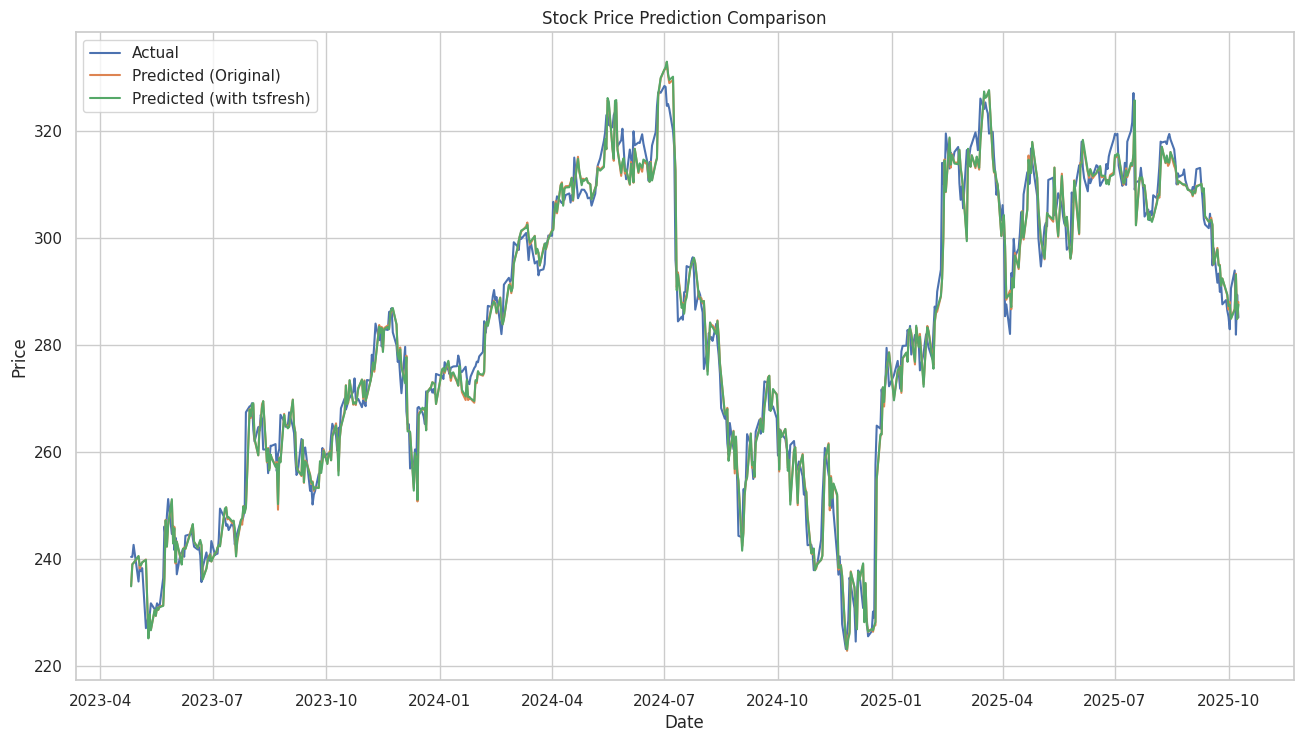

In [23]:
# Cell 16: Visualize predictions with tsfresh features
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted (Original)')
plt.plot(y_test.index, y_pred_tsfresh, label='Predicted (with tsfresh)')
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

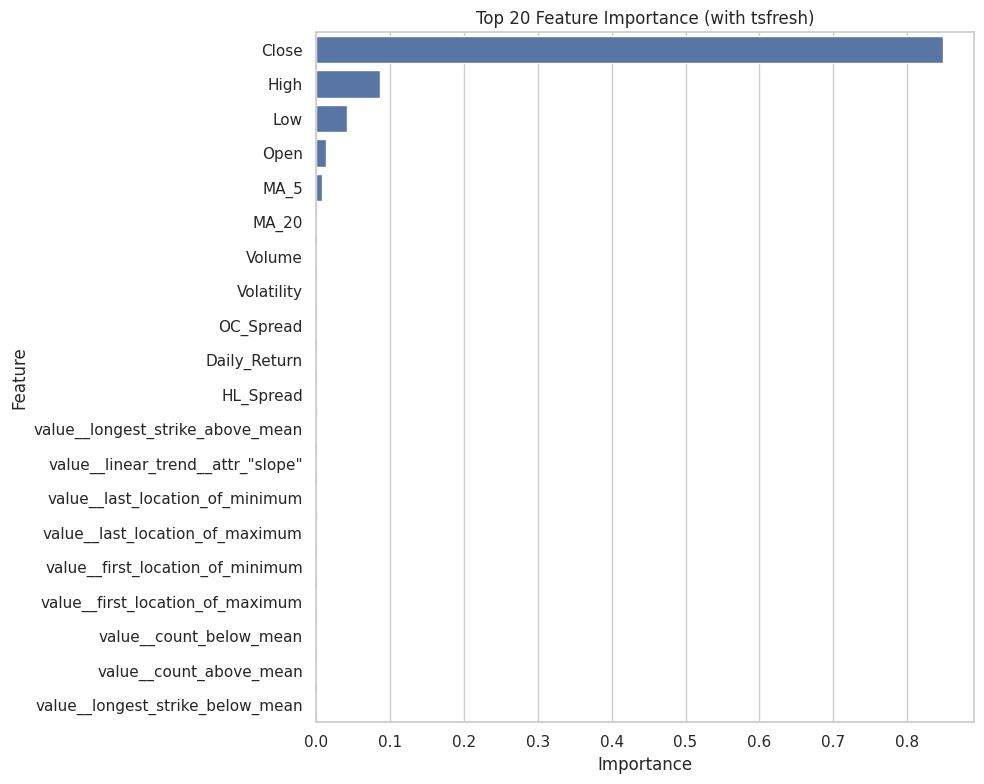

Top 20 Feature Importance:
                              Feature  Importance
3                               Close    0.847877
1                                High    0.086373
2                                 Low    0.042462
0                                Open    0.013373
8                                MA_5    0.008555
9                               MA_20    0.000291
4                              Volume    0.000265
10                         Volatility    0.000250
7                           OC_Spread    0.000197
5                        Daily_Return    0.000181
6                           HL_Spread    0.000176
20   value__longest_strike_above_mean    0.000000
28  value__linear_trend__attr_"slope"    0.000000
27    value__last_location_of_minimum    0.000000
26    value__last_location_of_maximum    0.000000
25   value__first_location_of_minimum    0.000000
24   value__first_location_of_maximum    0.000000
23            value__count_below_mean    0.000000
22            value__co

In [24]:
# Cell 17: Feature importance with tsfresh features
# Get feature importance from the model with tsfresh features
feature_importance_tsfresh = pd.DataFrame({
    'Feature': all_features,
    'Importance': model_tsfresh.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance_tsfresh.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Feature Importance (with tsfresh)')
plt.tight_layout()
plt.show()

print("Top 20 Feature Importance:")
print(top_features)

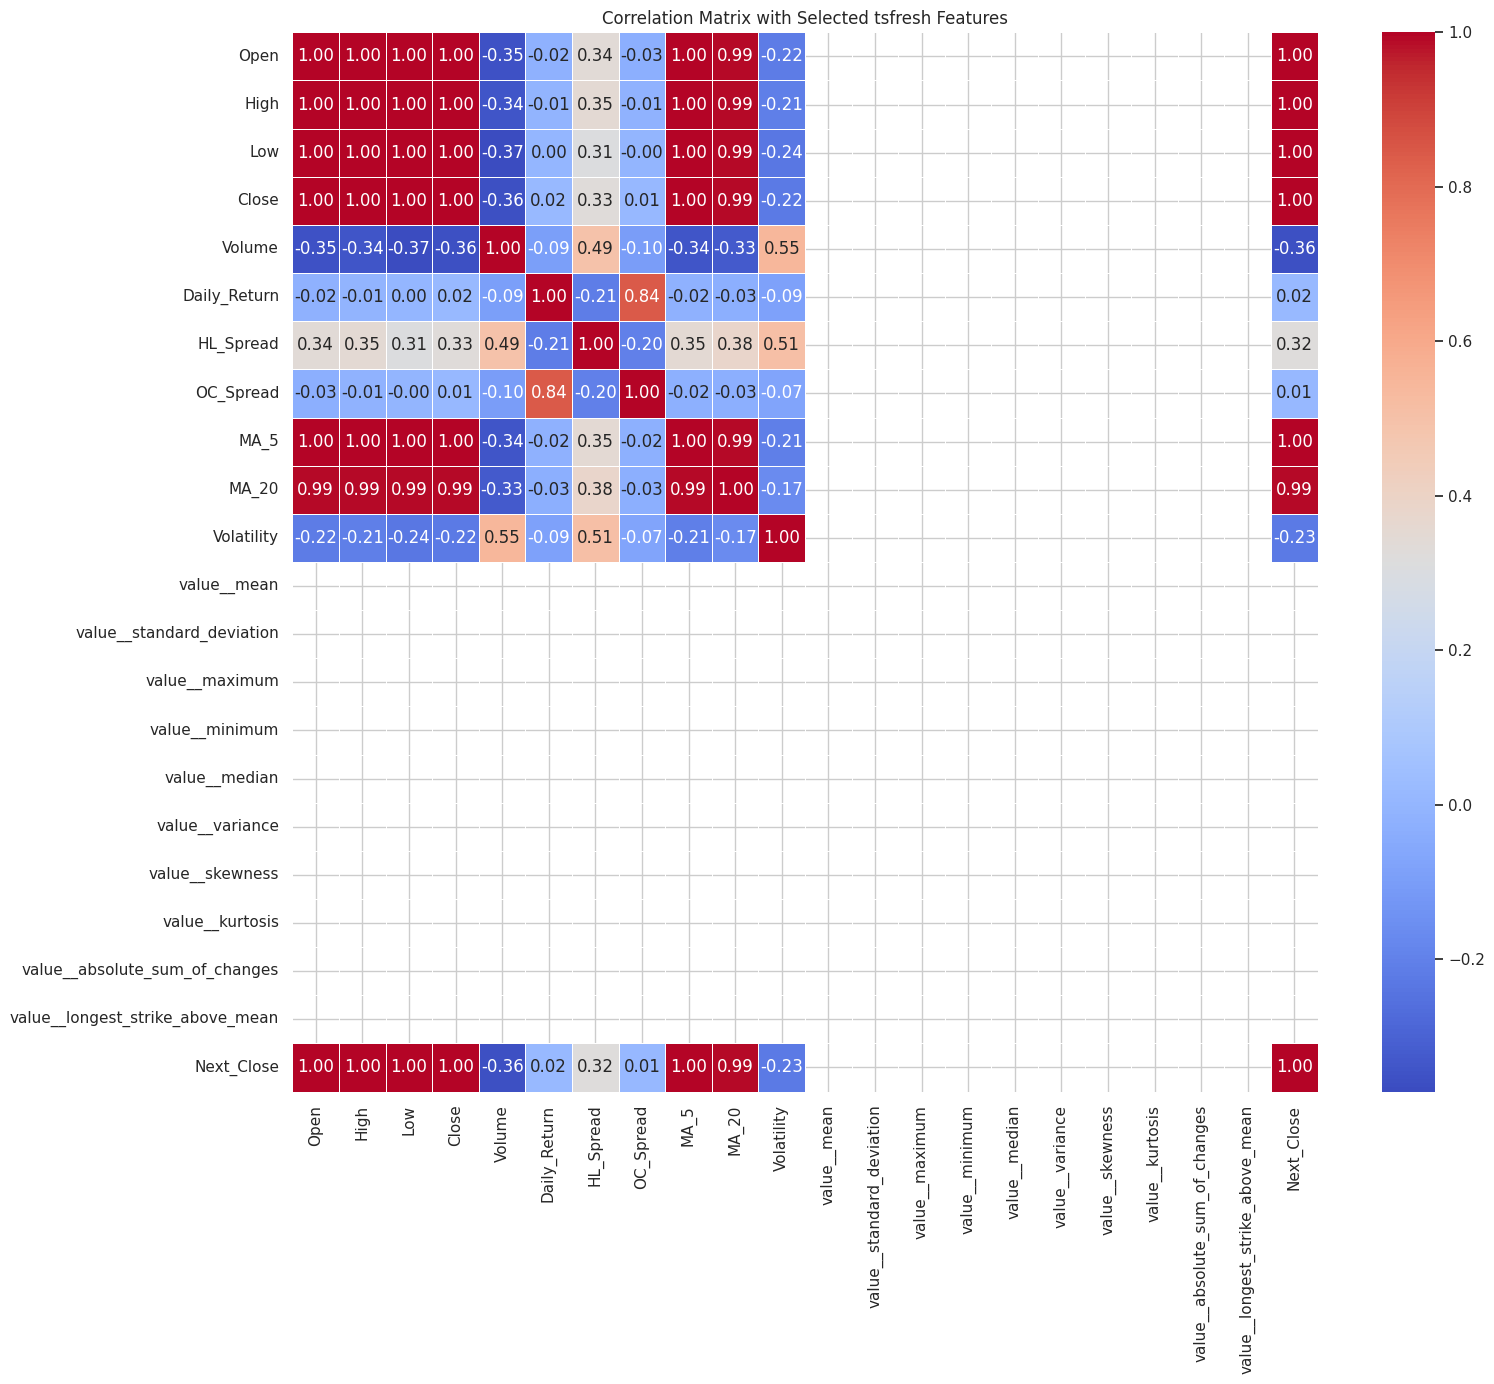

In [25]:
# Cell 18: Correlation matrix with tsfresh features
# Create a correlation matrix with a subset of tsfresh features
tsfresh_corr_features = existing_tsfresh_features[:10]  # Select first 10 tsfresh features
corr_features = original_features + tsfresh_corr_features + [target]

plt.figure(figsize=(16, 14))
correlation_matrix_tsfresh = df_with_tsfresh[corr_features].corr()
sns.heatmap(correlation_matrix_tsfresh, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix with Selected tsfresh Features')
plt.tight_layout()
plt.show()